# Code Review

This notebook uses the molecular graph regression dataset from the HW4 GNN Kaggle competition (38-616/09-616, S25): https://www.kaggle.com/competitions/s25-09616-hw4. Each molecule is stored in `train.pt` as a PyG graph with 11-dim node features and 4-dim edge features, and the task is to predict a scalar target property. I train an NNConv + Set2Set graph neural network on `train.pt`, using a local train/val/test split and MAE as the main evaluation metric, and then optionally add PerforatedAI (PAI) on top of the same backbone to study its effect on performance.


In [8]:
import os
import time
import csv
import math
import random
import numpy as np
from dataclasses import dataclass
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, Set2Set, GraphNorm
from torch.nn import Linear, ReLU, Sequential
import matplotlib.pyplot as plt
from perforatedai import globals_perforatedai as GPA

# ================== Configuration ==================
@dataclass
class CFG:
    train_path: str = 'drive/MyDrive/train.pt'
    save_dir: str   = './outputs'
    save_name: str  = 'PAI'      # subdir name for PAI artifacts (plots + CSVs)
    seed: int       = 60

    # Model & training
    dim: int        = 64
    n_layers: int   = 3
    dropout: float  = 0.1
    batch_size: int = 128
    max_epochs: int = 200
    lr: float       = 5e-4
    weight_decay: float = 0.0
    grad_clip: float = 2.0
    use_amp: bool   = True

    # LR scheduler (used explicitly for the Baseline;
    # for PAI, the tracker handles stepping internally)
    scheduler_factor: float = 0.5
    scheduler_patience: int = 5
    patience: int   = 20
    min_lr: float   = 1e-6

    # DataLoader
    num_workers: int = 2
    pin_memory: bool = True

    # Data splits
    val_size: int   = 2000
    test_size: int  = 2000
    val_ratio: float  = 0.05
    test_ratio: float = 0.10

CFG = CFG()

# For CUDA determinism (where supported)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

# ================== Reproducibility ==================
def set_seed(seed: int = 60):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    try:
        torch.use_deterministic_algorithms(True)
    except Exception:
        pass
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(CFG.seed)

def _seed_worker(worker_id):
    worker_seed = (torch.initial_seed() % 2**32)
    np.random.seed(worker_seed)
    random.seed(worker_seed)

def make_loader(dataset, batch_size, shuffle, num_workers, pin_memory, seed):
    g = torch.Generator()
    g.manual_seed(seed)
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory,
        worker_init_fn=_seed_worker if num_workers > 0 else None,
        generator=g
    )

# ================== Dataset wrapper ==================
class QM_Dataset(Dataset):
    def __init__(self, path: str):
        super().__init__(root='.')
        self.data = torch.load(path, weights_only=False)

    def len(self):
        return len(self.data)

    def get(self, idx):
        return self.data[idx]

# ================== Edge network & GNN ==================
def make_edge_mlp(edge_in: int, out_dim_sq: int) -> nn.Sequential:
    hidden = max(64, min(256, 2 * edge_in))
    return Sequential(
        Linear(edge_in, hidden),
        ReLU(),
        Linear(hidden, out_dim_sq)
    )

class NNConvBlock(nn.Module):
    def __init__(self, dim: int, edge_in: int, dropout: float):
        super().__init__()
        self.edge_in = edge_in
        self.nn_kernel = make_edge_mlp(edge_in, dim * dim)
        self.conv = NNConv(dim, dim, self.nn_kernel, aggr='mean')
        self.norm = GraphNorm(dim)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, edge_index, edge_attr, batch):
        assert edge_attr is not None
        assert edge_attr.size(-1) == self.edge_in, \
            f"edge_attr.size(-1)={edge_attr.size(-1)} != {self.edge_in}"
        res = x
        x = F.relu(self.conv(x, edge_index, edge_attr), inplace=True)
        x = self.norm(x, batch)
        x = self.drop(x)
        return x + res

class Net(nn.Module):
    def __init__(self, num_features: int, edge_in: int, dim: int = 64,
                 n_layers: int = 3, dropout: float = 0.1, set2set_steps: int = 3):
        super().__init__()
        self.lin0 = Linear(num_features, dim)
        self.layers = nn.ModuleList([
            NNConvBlock(dim=dim, edge_in=edge_in, dropout=dropout)
            for _ in range(n_layers)
        ])
        self.set2set = Set2Set(dim, processing_steps=set2set_steps)
        self.head = nn.Sequential(
            Linear(2 * dim, dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            Linear(dim, 1)
        )

    def forward(self, data):
        x, ei, ea, b = data.x, data.edge_index, data.edge_attr, data.batch
        assert x.dim() == 2 and ea is not None and ea.dim() == 2
        x = F.relu(self.lin0(x), inplace=True)
        for layer in self.layers:
            x = layer(x, ei, ea, b)
        g = self.set2set(x, b)
        return self.head(g).view(-1)

# ================== Evaluation ==================
@torch.no_grad()
def eval_loader(model, loader, device):
    model.eval()
    mae_sum, mse_sum, n_graph = 0.0, 0.0, 0
    for data in loader:
        data = data.to(device)
        pred = model(data)
        y = data.y.view(-1)
        mae_sum += (pred - y).abs().sum().item()
        mse_sum += F.mse_loss(pred, y, reduction='sum').item()
        n_graph += data.num_graphs
    return mae_sum / n_graph, mse_sum / n_graph

# ================== Experiment logger (CSV + plots) ==================
class ExperimentLogger:
    """Collect per-epoch and per-cycle metrics and export CSVs/plots."""
    def __init__(self, root_dir):
        self.root = root_dir
        os.makedirs(self.root, exist_ok=True)

        # Per-epoch
        self.epochs = []
        self.val = []
        self.val_running = []
        self.train_extra = []
        self.test_at_valbest = []
        self.times = []
        self.lrs = []
        self.switch_epochs_blue = []

        # Per-cycle
        self.param_counts = []      # (cycle_id, param_count)
        self.best_test_rows = []    # (param_count, best_val, test_at_best)

    def add_epoch(self, epoch, val, running_val, lr, elapsed, test_at_best_or_none):
        self.epochs.append(epoch)
        self.val.append(val)
        self.val_running.append(running_val)
        self.lrs.append(lr)
        self.times.append(elapsed)
        self.test_at_valbest.append(test_at_best_or_none)

    def mark_switch_back_to_neuron(self, epoch):
        self.switch_epochs_blue.append(epoch)

    def add_param_count(self, n_params):
        self.param_counts.append((len(self.param_counts), n_params))

    def add_cycle_best_row(self, param_count, best_val, test_at_best):
        self.best_test_rows.append((param_count, best_val, test_at_best))

    def _write_csv(self, name, header, rows):
        path = os.path.join(self.root, f"{name}.csv")
        with open(path, "w", newline="") as f:
            w = csv.writer(f)
            w.writerow(header)
            w.writerows(rows)

    def dump_csvs(self):
        # Scores.csv
        rows_scores = []
        for i in range(len(self.epochs)):
            rows_scores.append([
                self.epochs[i],
                self.val[i],
                self.val_running[i],
                "" if i >= len(self.train_extra) else self.train_extra[i],
                "" if self.test_at_valbest[i] is None else self.test_at_valbest[i],
            ])
        self._write_csv("Scores", ["epoch", "val", "running_val", "extra", "test_at_valbest"], rows_scores)

        # Times.csv
        self._write_csv("Times", ["epoch", "time_sec"], list(zip(self.epochs, self.times)))

        # LearningRate.csv
        self._write_csv("LearningRate", ["epoch", "learning_rate"], list(zip(self.epochs, self.lrs)))

        # paramCounts.csv
        self._write_csv("paramCounts", ["cycle_id", "param_count"], self.param_counts)

        # switchEpochs.csv
        self._write_csv("switchEpochs", ["epoch_switch_back_to_neuron"], [[e] for e in self.switch_epochs_blue])

        # best_test_scores.csv
        self._write_csv("best_test_scores", ["param_count", "best_val", "test_at_best"], self.best_test_rows)

    def draw_plots(self):
        fig, axes = plt.subplots(2, 2, figsize=(14, 8))
        ax_scores = axes[0, 0]
        ax_times = axes[0, 1]
        ax_lr = axes[1, 0]
        ax_pb = axes[1, 1]

        # (1) Scores
        ax_scores.plot(self.epochs, self.val, color='tab:orange', label='Validation Scores')
        ax_scores.plot(self.epochs, self.val_running, color='tab:red', label='Validation Running Scores')

        xs_t, ys_t = [], []
        for i, v in enumerate(self.test_at_valbest):
            if v is not None:
                xs_t.append(self.epochs[i])
                ys_t.append(v)
        if len(xs_t) > 0:
            ax_scores.scatter(xs_t, ys_t, c='tab:green', s=16, label='Test@ValBest')

        for e in self.switch_epochs_blue:
            ax_scores.axvline(e, color='tab:blue')

        ax_scores.set_title('./PB//PBScores')
        ax_scores.set_xlabel('Epochs')
        ax_scores.set_ylabel('Score')
        ax_scores.legend(loc='lower right')

        # (2) Times
        ax_times.plot(self.epochs, self.times, label='Normal Epoch Times')
        ax_times.set_title('./PB//PB(times by train() and eval())')
        ax_times.set_xlabel('Iteration')
        ax_times.set_ylabel('Epoch Time in Seconds')
        ax_times.legend()

        # (3) Learning rate
        ax_lr.plot(self.epochs, self.lrs, label='learning_rate')
        ax_lr.set_title('./PB//PBlearning_rate')
        ax_lr.set_xlabel('Epochs')
        ax_lr.set_ylabel('learning_rate')
        ax_lr.legend(loc='upper right')

        # (4) Placeholder (kept to match original layout)
        ax_pb.set_title('./PB//PB Best PBScores')
        ax_pb.set_xlabel('Epochs')
        ax_pb.set_ylabel('PB Scores')

        fig.tight_layout()
        out_png = os.path.join(self.root, 'pai_plots.png')
        fig.savefig(out_png, dpi=150)
        plt.close(fig)

# ================== PAI controller wrapper ==================
class PAIController:
    def __init__(self, save_name='PAI', maximizing_score=False):
        self.save_name = save_name
        self.maximizing = maximizing_score
        self.enabled = False
        self.GPA = None
        self.UPA = None

    def _auto_set_not_save_names(self, model: nn.Module):
        names = ['.base_model']
        for name, _ in model.named_modules():
            if name.endswith('nn_kernel'):
                names.append('.' + name)
                twin = name.replace('nn_kernel', 'conv.nn')
                names.append('.' + twin)
        try:
            if hasattr(self.GPA, "pc") and hasattr(self.GPA.pc, "set_module_names_to_not_save"):
                self.GPA.pc.set_module_names_to_not_save(names)
                print(f"[PAI] set_module_names_to_not_save -> {names}")
        except Exception as e:
            print("[PAI] set_module_names_to_not_save failed:", e)

    def maybe_initialize(self, model: nn.Module):
        try:
            from perforatedai import globals_perforatedai as GPA
            from perforatedai import utils_perforatedai as UPA
            self.GPA, self.UPA = GPA, UPA
        except Exception as e:
            print("[PAI] import failed, fallback to baseline:", e)
            return model

        try:
            if hasattr(self.GPA, "pc") and hasattr(self.GPA.pc, "set_unwrapped_modules_confirmed"):
                self.GPA.pc.set_unwrapped_modules_confirmed(True)
            try:
                self.GPA.pc.set_testing_dendrite_capacity(False)
            except Exception:
                pass
            try:
                self.GPA.pc.set_weight_decay_accepted(True)
            except Exception:
                pass

            self._auto_set_not_save_names(model)

            try:
                self.GPA.pc.set_using_safe_tensors(False)
            except Exception:
                pass

            try:
                model = self.UPA.initialize_pai(
                    model, doing_pai=True, save_name=self.save_name,
                    making_graphs=False, maximizing_score=self.maximizing
                )
            except TypeError:
                try:
                    model = self.UPA.initialize_pai(
                        model, doing_pai=True, save_name=self.save_name, making_graphs=False
                    )
                except TypeError:
                    model = self.UPA.initialize_pai(model)

            self.enabled = True
            print("[PAI] initialize_pai OK.")
        except SystemExit as e:
            print("[PAI] initialize_pai triggered SystemExit, disable PAI:", e)
            self.enabled = False
        except Exception as e:
            print("[PAI] initialize_pai failed, disable PAI:", e)
            self.enabled = False
        return model

    def on_validation(self, score: float, model: nn.Module):
        if not self.enabled:
            return model, False, False
        try:
            ret = self.GPA.pai_tracker.add_validation_score(score, model)
            if isinstance(ret, tuple) and len(ret) == 3:
                model, restructured, training_complete = ret
            else:
                model, restructured, training_complete = ret, False, False
            return model, bool(restructured), bool(training_complete)
        except Exception as e:
            print("[PAI] add_validation_score failed:", e)
            return model, False, False

    def add_test_score_safe(self, score):
        if not self.enabled:
            return
        try:
            self.GPA.pai_tracker.add_test_score(score)
        except Exception:
            pass

    def add_extra_score_safe(self, score, name='train'):
        if not self.enabled:
            return
        try:
            self.GPA.pai_tracker.add_extra_score(score, name)
        except Exception:
            pass

# ================== Training loop (Baseline + PAI) ==================
def train_one_model(model, train_loader, val_loader, test_loader, device, save_path,
                    use_amp=True, max_epochs=100, lr=5e-4, wd=1e-5, grad_clip=2.0,
                    sch_factor=0.5, sch_patience=5, min_lr=1e-6, early_patience=20,
                    pai_ctrl: "PAIController | None" = None,
                    exp_logger: "ExperimentLogger | None" = None):

    # Optimizer + scheduler: either via PAI or normal PyTorch
    if pai_ctrl is not None and pai_ctrl.enabled:
        from perforatedai import globals_perforatedai as GPA
        GPA.pai_tracker.set_optimizer(torch.optim.Adam)
        GPA.pai_tracker.set_scheduler(torch.optim.lr_scheduler.ReduceLROnPlateau)
        optimArgs = {'params': model.parameters(), 'lr': lr, 'weight_decay': wd}
        schedArgs = {'mode': 'min', 'patience': sch_patience, 'factor': sch_factor, 'min_lr': min_lr}
        optimizer, scheduler = GPA.pai_tracker.setup_optimizer(model, optimArgs, schedArgs)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=sch_factor, patience=sch_patience, min_lr=min_lr
        )

    # Native AMP
    use_native_amp = use_amp and torch.cuda.is_available()
    scaler = torch.amp.GradScaler('cuda', enabled=use_native_amp)

    # Cycle-level bookkeeping
    improve_eps = 1e-4
    cycle_id = 0
    cycle_best_val = float('inf')
    cycle_best_pair = None    # (best_val, test_at_best)
    all_cycles = []

    # Param count for the initial architecture
    n_params = sum(p.numel() for p in model.parameters())
    if exp_logger is not None:
        exp_logger.add_param_count(n_params)

    best_val_mae = float('inf')
    running_best = float('inf')
    wait = 0

    for epoch in range(1, max_epochs + 1):
        t0 = time.time()
        model.train()
        running_loss, n_graph = 0.0, 0

        for data in train_loader:
            data = data.to(device)
            optimizer.zero_grad(set_to_none=True)
            if use_native_amp:
                with torch.amp.autocast('cuda'):
                    pred = model(data)
                    y = data.y.view(-1)
                    loss = F.mse_loss(pred, y)
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                scaler.step(optimizer)
                scaler.update()
            else:
                pred = model(data)
                y = data.y.view(-1)
                loss = F.mse_loss(pred, y)
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
                optimizer.step()

            running_loss += loss.item() * data.num_graphs
            n_graph += data.num_graphs

        train_mse = running_loss / n_graph

        # Validation
        val_mae, val_mse = eval_loader(model, val_loader, device)

        # Scheduler stepping for the Baseline only
        if (pai_ctrl is None) or (not pai_ctrl.enabled):
            scheduler.step(val_mae)

        # Track best val; whenever val improves, evaluate on test
        test_at_best_or_none = None
        if val_mae < best_val_mae - 1e-6:
            best_val_mae = val_mae
            best_state = copy.deepcopy(model.state_dict())
            best_epoch = epoch
            test_mae_at_best, _ = eval_loader(model, test_loader, device)
            test_at_best_or_none = test_mae_at_best
            if pai_ctrl is not None and pai_ctrl.enabled:
                pai_ctrl.add_test_score_safe(test_mae_at_best)
            wait = 0
        else:
            wait += 1

        running_best = min(running_best, val_mae)

        lr_now = optimizer.param_groups[0]['lr']
        elapsed = time.time() - t0
        if exp_logger is not None:
            exp_logger.add_epoch(epoch, val_mae, running_best, lr_now, elapsed, test_at_best_or_none)

        # PAI validation hook (may trigger restructuring or early completion)
        restructured = False
        training_complete = False
        if pai_ctrl is not None and pai_ctrl.enabled:
            model, restructured, training_complete = pai_ctrl.on_validation(val_mae, model)
            if training_complete:
                print("[PAI] training_complete signaled by tracker.")
                if cycle_best_pair is not None:
                    all_cycles.append((cycle_id, cycle_best_pair[0], cycle_best_pair[1]))
                break

        # If restructuring happens, we mark a new cycle boundary
        if restructured:
            if exp_logger is not None:
                exp_logger.mark_switch_back_to_neuron(epoch)

            # Close current cycle and optionally early-stop on cycles
            if cycle_best_pair is not None:
                all_cycles.append((cycle_id, cycle_best_pair[0], cycle_best_pair[1]))
                if len(all_cycles) >= 2:
                    prev_best = all_cycles[-2][1]
                    curr_best = all_cycles[-1][1]
                    if curr_best > prev_best - improve_eps:
                        print(
                            f"[EarlyStop@Cycle] cycle {cycle_id} best {curr_best:.6f} "
                            f"did not beat prev {prev_best:.6f} (eps={improve_eps})"
                        )
                        break

            cycle_id += 1
            cycle_best_val = float('inf')
            cycle_best_pair = None

            # New param count after restructuring
            n_params = sum(p.numel() for p in model.parameters())
            if exp_logger is not None:
                exp_logger.add_param_count(n_params)

            # Rebuild optimizer/scheduler through PAI tracker
            from perforatedai import globals_perforatedai as GPA
            model.to(device)
            optimArgs = {'params': model.parameters(), 'lr': lr, 'weight_decay': wd}
            schedArgs = {'mode': 'min', 'patience': sch_patience, 'factor': sch_factor, 'min_lr': min_lr}
            optimizer, scheduler = GPA.pai_tracker.setup_optimizer(model, optimArgs, schedArgs)

        # Update current cycle's best (val, test)
        if test_at_best_or_none is not None:
            if best_val_mae < cycle_best_val - 1e-6:
                cycle_best_val = best_val_mae
                cycle_best_pair = (best_val_mae, test_at_best_or_none)

        # Console logging
        if epoch % 10 == 0 or epoch == 1:
            print(
                f"Epoch {epoch:03d} | Train MSE {train_mse:.5f} | "
                f"Val MAE {val_mae:.5f} | Val MSE {val_mse:.5f} | LR {lr_now:.2e}"
            )

        # Standard early stopping based on steady val MAE
        if wait >= early_patience:
            print(f"[EarlyStopping] no improve for {early_patience} epochs.")
            break

    # Add last cycle if not yet recorded
    if cycle_best_pair is not None:
        all_cycles.append((cycle_id, cycle_best_pair[0], cycle_best_pair[1]))

    # Export cycle-level stats and plots
    if exp_logger is not None:
        for (cid, vbest, tbest), (_, pcount) in zip(all_cycles, exp_logger.param_counts):
            exp_logger.add_cycle_best_row(pcount, vbest, tbest)
        exp_logger.dump_csvs()
        exp_logger.draw_plots()

    return best_val_mae

# ================== Main entry point ==================
def main():
    os.makedirs(CFG.save_dir, exist_ok=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pin_memory = (device.type == 'cuda') and CFG.pin_memory
    print(f"[Device] {device}")

    # Load full dataset
    full_train = QM_Dataset(CFG.train_path)
    N = full_train.len()
    sample = full_train.get(0)
    num_features = sample.x.size(-1)
    edge_in = sample.edge_attr.size(-1)
    print(f"[Info] N={N}, num_features={num_features}, edge_in={edge_in}")

    # Train/val/test split
    if CFG.val_size <= 0:
        val_size = max(1, int(N * CFG.val_ratio))
    else:
        val_size = min(CFG.val_size, N - 2)
    remain = N - val_size
    if CFG.test_size <= 0:
        test_size = max(1, int(N * CFG.test_ratio))
    else:
        test_size = min(CFG.test_size, remain - 1)
    train_size = remain - test_size
    assert train_size > 0 and val_size > 0 and test_size > 0, "Invalid split sizes"

    train_set, val_set, test_set = random_split(
        full_train, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(CFG.seed)
    )
    print(f"[Split] train={len(train_set)}, val={len(val_set)}, test(held-out)={len(test_set)}")

    train_loader = make_loader(train_set, CFG.batch_size, True,  CFG.num_workers, pin_memory, CFG.seed)
    val_loader   = make_loader(val_set,   CFG.batch_size, False, CFG.num_workers, pin_memory, CFG.seed)
    test_loader  = make_loader(test_set,  CFG.batch_size, False, CFG.num_workers, pin_memory, CFG.seed)

    # ----- Baseline -----
    print("\n[Baseline] training...")
    base_model_cpu = Net(num_features=num_features, edge_in=edge_in,
                         dim=CFG.dim, n_layers=CFG.n_layers, dropout=CFG.dropout)
    base_model = base_model_cpu.to(device)
    base_ckpt = os.path.join(CFG.save_dir, 'baseline_best.pt')

    base_val_mae = train_one_model(
        base_model, train_loader, val_loader, test_loader, device, base_ckpt,
        use_amp=CFG.use_amp, max_epochs=CFG.max_epochs, lr=CFG.lr, wd=CFG.weight_decay,
        grad_clip=CFG.grad_clip, sch_factor=CFG.scheduler_factor,
        sch_patience=CFG.scheduler_patience, min_lr=CFG.min_lr, early_patience=CFG.patience,
        pai_ctrl=None, exp_logger=None
    )
    base_test_mae, base_test_mse = eval_loader(base_model, test_loader, device)
    print(f"[Baseline] Best Val MAE={base_val_mae:.6f} | Held-out Test MAE={base_test_mae:.6f}")

    # ----- PAI -----
    print("\n[PAI] trying to initialize...")
    pai_out_dir = os.path.join(CFG.save_dir, f"{CFG.save_name}_seed{CFG.seed}")
    exp_logger = ExperimentLogger(pai_out_dir)
    pai_ctrl = PAIController(save_name=CFG.save_name, maximizing_score=False)

    # Must initialize PAI on CPU before .to(device)
    pai_model_cpu = Net(num_features=num_features, edge_in=edge_in,
                        dim=CFG.dim, n_layers=CFG.n_layers, dropout=CFG.dropout)
    pai_model_cpu = pai_ctrl.maybe_initialize(pai_model_cpu)

    if not pai_ctrl.enabled:
        print("[PAI] Not installed/initialized. Skipping PAI run.")
    else:
        # Configure PAI switching strategy
        try:
            from perforatedai import globals_perforatedai as GPA
            try:
                GPA.pc.set_switch_mode(GPA.pc.DOING_HISTORY)
            except Exception:
                pass
            for fn, arg in [
                ("set_n_epochs_to_switch", 10),
                ("set_p_epochs_to_switch", 10),
                ("set_history_lookback", 1),
                ("set_improvementThreshold", 0.003),
            ]:
                try:
                    getattr(GPA.pc, fn)(arg)
                except Exception:
                    pass
        except Exception:
            pass

        pai_model = pai_model_cpu.to(device)
        print("[PAI] training with dendrites...")

        pai_ckpt = os.path.join(CFG.save_dir, 'pai_best.pt')
        pai_val_mae = train_one_model(
            pai_model, train_loader, val_loader, test_loader, device, pai_ckpt,
            use_amp=CFG.use_amp, max_epochs=CFG.max_epochs, lr=CFG.lr, wd=CFG.weight_decay,
            grad_clip=CFG.grad_clip, sch_factor=CFG.scheduler_factor,
            sch_patience=CFG.scheduler_patience, min_lr=CFG.min_lr, early_patience=CFG.patience,
            pai_ctrl=pai_ctrl, exp_logger=exp_logger
        )
        pai_test_mae, pai_test_mse = eval_loader(pai_model, test_loader, device)
        print(f"[PAI] Best Val MAE={pai_val_mae:.6f} | Held-out Test MAE={pai_test_mae:.6f}")

        print("\n===== RESULT COMPARISON (lower is better) =====")
        print(f"Val  MAE -> Baseline: {base_val_mae:.6f} | PAI: {pai_val_mae:.6f}")
        print(f"Test MAE -> Baseline: {base_test_mae:.6f} | PAI: {pai_test_mae:.6f}")
        print(f"[Artifacts] Saved plots & CSVs under: {pai_out_dir}")

if __name__ == "__main__":
    main()


[Device] cuda
[Info] N=20000, num_features=11, edge_in=4
[Split] train=16000, val=2000, test(held-out)=2000

[Baseline] training...
Epoch 001 | Train MSE 2.79596 | Val MAE 0.77794 | Val MSE 1.05121 | LR 5.00e-04
Epoch 010 | Train MSE 1.21941 | Val MAE 0.65724 | Val MSE 0.80605 | LR 5.00e-04
Epoch 020 | Train MSE 0.99841 | Val MAE 0.66086 | Val MSE 0.80584 | LR 5.00e-04
Epoch 030 | Train MSE 0.83966 | Val MAE 0.61625 | Val MSE 0.70160 | LR 2.50e-04
Epoch 040 | Train MSE 0.81698 | Val MAE 0.61176 | Val MSE 0.69354 | LR 2.50e-04
Epoch 050 | Train MSE 0.78188 | Val MAE 0.60596 | Val MSE 0.69388 | LR 2.50e-04
Epoch 060 | Train MSE 0.72417 | Val MAE 0.59482 | Val MSE 0.67675 | LR 1.25e-04
Epoch 070 | Train MSE 0.70936 | Val MAE 0.59373 | Val MSE 0.66577 | LR 1.25e-04
Epoch 080 | Train MSE 0.67575 | Val MAE 0.58839 | Val MSE 0.65608 | LR 3.13e-05
Epoch 090 | Train MSE 0.67571 | Val MAE 0.58794 | Val MSE 0.66041 | LR 1.56e-05
Epoch 100 | Train MSE 0.66338 | Val MAE 0.58746 | Val MSE 0.65976 | 

# Plots Analysis

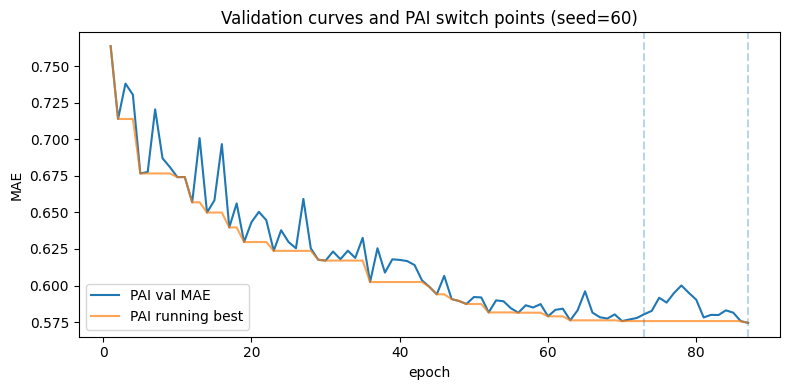

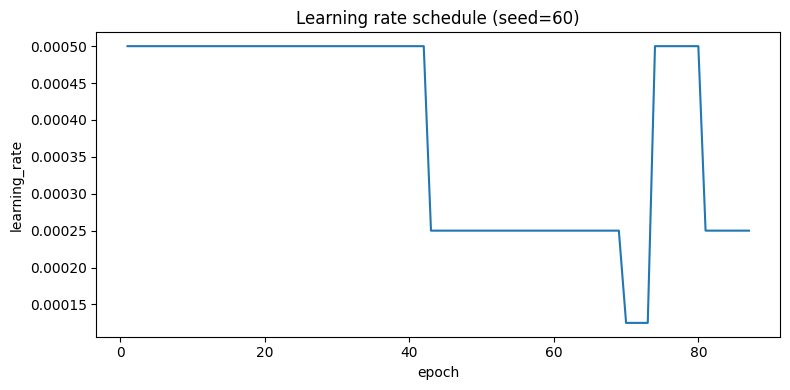

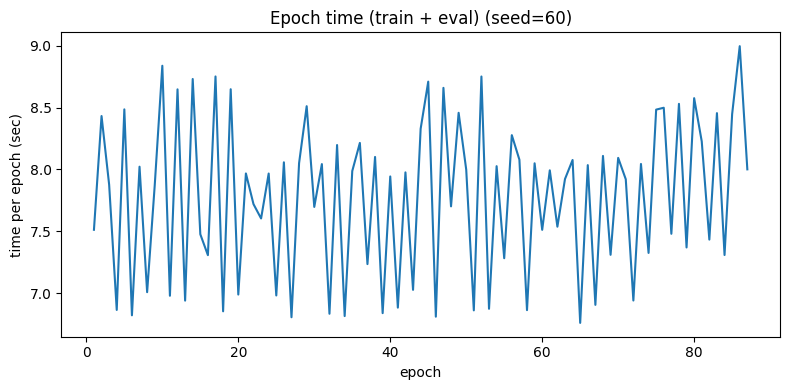

Average epoch time overall: 7.776s
Average before first switch (epoch < 73): 7.713s
Average after first switch  (epoch ≥ 73): 8.079s
Cycle-level summary:
   cycle_id  param_count  best_val  test_at_best
0         0       880578  0.575695      0.631096
1         1       889796  0.575655      0.644147

Best Val MAE across cycles: 0.5756554565429688
Best cycle id: 1


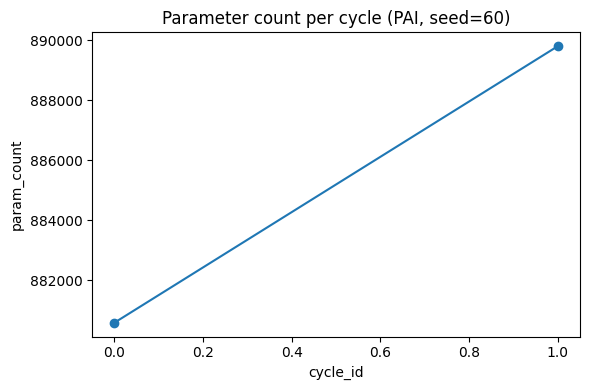

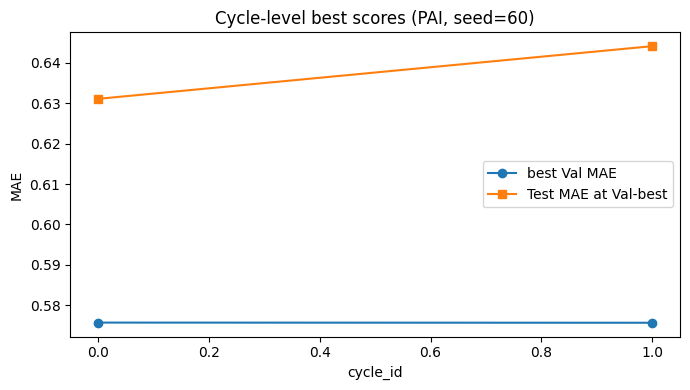

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import os

base_dir = '/content/drive/MyDrive/outputs/'

scores_path      = os.path.join(base_dir, 'Scores.csv')
switch_path      = os.path.join(base_dir, 'switchEpochs.csv')
lr_path          = os.path.join(base_dir, 'LearningRate.csv')
times_path       = os.path.join(base_dir, 'Times.csv')
param_path       = os.path.join(base_dir, 'paramCounts.csv')
best_cycle_path  = os.path.join(base_dir, 'best_test_scores.csv')


scores_pai  = pd.read_csv(scores_path)
switch      = pd.read_csv(switch_path)
lr_df       = pd.read_csv(lr_path)
times_df    = pd.read_csv(times_path)
param_df    = pd.read_csv(param_path)
best_df     = pd.read_csv(best_cycle_path)

#1. val curve
plt.figure(figsize=(8, 4))
plt.plot(scores_pai['epoch'], scores_pai['val'], label='PAI val MAE')
plt.plot(scores_pai['epoch'], scores_pai['running_val'], label='PAI running best', alpha=0.7)

for e in switch['epoch_switch_back_to_neuron']:
    plt.axvline(e, color='tab:blue', alpha=0.3, linestyle='--')

plt.xlabel('epoch')
plt.ylabel('MAE')
plt.title('Validation curves and PAI switch points (seed=60)')
plt.legend()
plt.tight_layout()
plt.show()

# 2. LearningRate
plt.figure(figsize=(8, 4))
plt.plot(lr_df['epoch'], lr_df['learning_rate'])
plt.xlabel('epoch')
plt.ylabel('learning_rate')
plt.title('Learning rate schedule (seed=60)')
plt.tight_layout()
plt.show()

# 3. Times
plt.figure(figsize=(8, 4))
plt.plot(times_df['epoch'], times_df['time_sec'])
plt.xlabel('epoch')
plt.ylabel('time per epoch (sec)')
plt.title('Epoch time (train + eval) (seed=60)')
plt.tight_layout()
plt.show()

if len(switch) > 0:
    first_switch = switch['epoch_switch_back_to_neuron'].iloc[0]
    before = times_df[times_df['epoch'] < first_switch]['time_sec']
    after  = times_df[times_df['epoch'] >= first_switch]['time_sec']
    print(f'Average epoch time overall: {times_df["time_sec"].mean():.3f}s')
    print(f'Average before first switch (epoch < {first_switch}): {before.mean():.3f}s')
    print(f'Average after first switch  (epoch ≥ {first_switch}): {after.mean():.3f}s')
else:
    print('No switch epochs recorded.')



# 4.1 paramCounts + best_test_scores
# param_df: cycle_id, param_count
# best_df : param_count, best_val, test_at_best
cycle_df = pd.merge(param_df, best_df, on='param_count', how='inner')
cycle_df = cycle_df.sort_values('cycle_id').reset_index(drop=True)

print('Cycle-level summary:')
print(cycle_df)
print('\nBest Val MAE across cycles:', cycle_df['best_val'].min())
best_cycle = cycle_df.loc[cycle_df['best_val'].idxmin(), 'cycle_id']
print('Best cycle id:', best_cycle)

# 4.2 param/ cycle
plt.figure(figsize=(6, 4))
plt.plot(cycle_df['cycle_id'], cycle_df['param_count'], marker='o')
plt.xlabel('cycle_id')
plt.ylabel('param_count')
plt.title('Parameter count per cycle (PAI, seed=60)')
plt.tight_layout()
plt.show()

# 4.3 cycle best_val / test_at_best
plt.figure(figsize=(7, 4))
plt.plot(cycle_df['cycle_id'], cycle_df['best_val'],
         marker='o', label='best Val MAE')
plt.plot(cycle_df['cycle_id'], cycle_df['test_at_best'],
         marker='s', label='Test MAE at Val-best')

plt.xlabel('cycle_id')
plt.ylabel('MAE')
plt.title('Cycle-level best scores (PAI, seed=60)')
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
import pandas as pd

best = pd.read_csv('/content/drive/MyDrive/outputs/best_test_scores.csv')
params = pd.read_csv('/content/drive/MyDrive/outputs/paramCounts.csv')

df = params.merge(best, on='param_count')
df


,cycle_id,param_count,best_val,test_at_best
0,0,880578,0.575695,0.631096
1,1,889796,0.575655,0.644147
